In [6]:
import os
import pandas as pd
from urllib.parse import parse_qs
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [7]:
# type_exp = ["randomExample", "dynamic", "placeholder", "dynamic-r2"]
type_exp = [
    "placeholder",
    "randomExamples",
    "dynamic",
    "dynamicPlaceholder",
    "EmbeddedPlaceholder",
    "TFIDFPlaceholder",
]

# Initialize an array to store the cumulative successes for all indices
successes_data = {}
df_data = {}
benchmarks = ["libraries", "cedar", "dafnyVMC"]
lengths = {"libraries": 58, "cedar": 54, "dafnyVMC": 33}
for benchmark in benchmarks:
    for method in type_exp:
        df = pd.DataFrame()
        for i in range(lengths[benchmark]):
            if os.path.exists(
                # f"../results_llm/tmp_{benchmark}/output_{method}_{benchmark}_{i}.csv"
                f"../results_llm/tmp_{benchmark}/output_{method}-r3_{benchmark}_{i}.csv"
            ):
                # print(f"Reading file {i}")
                df_temp = pd.read_csv(
                    f"../results_llm/tmp_{benchmark}/output_{method}-r3_{benchmark}_{i}.csv"
                )
                df_temp["Index"] = i
                df = pd.concat([df, df_temp], ignore_index=True)
        # print(df.shape)
        if df.shape[0] == 0:
            continue
        df_data[(method, benchmark)] = df

        cumulative_successes = [0 * 10]
        # Iterate over the range of tries
        for try_number in range(10):
            # Get the successes for the current try and all previous tries
            successes = df[
                (df["New Method Result"] == "Correct") & (df["Try"] <= try_number)
            ]
            # Count the number of unique indices that were successful
            cumulative_successes.append(successes["Index"].nunique())

            successes_data[(method, benchmark)] = cumulative_successes

normalized_cumulative_success = {}

for (method, benchmark), cumulative_successes in successes_data.items():
    print(f"Method: {method}, Benchmark: {benchmark}")

    # Normalize the cumulative successes
    total_indices = df_data[(method, benchmark)]["Index"].nunique()
    normalized_cumulative_success[(method, benchmark)] = [
        100.0 * successes / total_indices for successes in cumulative_successes
    ]

/tmp/ipykernel_1906935/2121345180.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], ignore_index=True)
/tmp/ipykernel_1906935/2121345180.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp], ignore_index=True)
/tmp/ipykernel_1906935/2121345180.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determinin

EmptyDataError: No columns to parse from file

In [ ]:
# Initialize an empty dictionary to store the success and failure methods for each benchmark
methods = {}
methods_non_html = {}
# Iterate over the results dictionary
for (method, benchmark), df in df_data.items():
    # Group the DataFrame by index
    for index, group in df.groupby("Index"):
        # Check if there's at least one success
        if (group["New Method Result"] == "Correct").any():
            success_method = method
            fail_method = None
        else:
            success_method = None
            fail_method = method

        # Get the URL from the group
        url = group["Url"].iloc[0]  # Assuming all rows in the group have the same URL

        # Add the methods to the dictionary
        if benchmark not in methods:
            methods[benchmark] = {}
            methods_non_html[benchmark] = {}
        if index not in methods[benchmark]:
            methods[benchmark][index] = {"Success": [], "Fail": []}
            methods_non_html[benchmark][index] = {"Success": [], "Fail": []}
        if success_method:
            methods_non_html[benchmark][index]["Success"].append(success_method)
            methods[benchmark][index]["Success"].append(
                '<a href="{}">{}</a>'.format(url, success_method)
            )
        if fail_method:
            methods_non_html[benchmark][index]["Fail"].append(fail_method)
            methods[benchmark][index]["Fail"].append(
                '<a href="{}">{}</a>'.format(url, fail_method)
            )

# Convert the dictionary to a DataFrame
df_methods = pd.DataFrame.from_dict(
    {(i, j): methods[i][j] for i in methods.keys() for j in methods[i].keys()},
    orient="index",
)
df_methods_non_html = pd.DataFrame.from_dict(
    {
        (i, j): methods_non_html[i][j]
        for i in methods_non_html.keys()
        for j in methods_non_html[i].keys()
    },
    orient="index",
)

# Convert the DataFrame to HTML and display it
df_methods_html = df_methods.to_html(escape=False)
display(HTML(df_methods_html))

In [ ]:
dynamic = set(
    df_methods_non_html[
        df_methods_non_html.apply(
            lambda row: any("dynamic" in sublist for sublist in row["Success"]), axis=1
        )
    ].index
)
rnd = set(
    df_methods_non_html[
        df_methods_non_html.apply(
            lambda row: any("randomExample" in sublist for sublist in row["Success"]),
            axis=1,
        )
    ].index
)

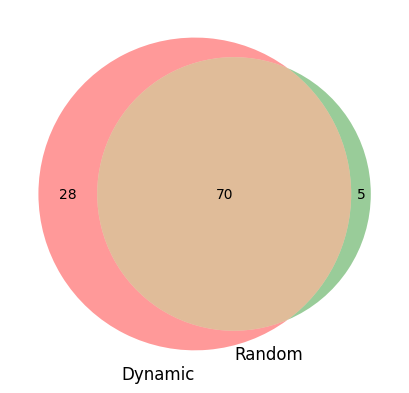

In [ ]:
from matplotlib_venn import venn2, venn3

venn = venn2([dynamic, rnd], set_labels=("Dynamic", "Random", "Both"))
plt.show()